In [1]:
import numpy as np
import cv2 as cv
import os
from matplotlib import pyplot as plt
import skimage
from skimage import measure, color, io
import scipy
import pandas as pd
%matplotlib inline

In [2]:
img_dataset_path = "/home/devesh/cell-segmentation/images/"
img_names = os.listdir(img_dataset_path)
img_names.sort()
img_names.remove('.DS_Store')
img_names.remove('.ipynb_checkpoints')

In [3]:
#Helper Functions
def bgr2rgb(img):
    new_img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    return new_img

def bgr2hsv(img):
    new_img = cv.cvtColor(img,cv.COLOR_BGR2HSV)
    return new_img

def hsv2bgr(img):
    new_img = cv.cvtColor(img,cv.COLOR_HSV2BGR)
    return new_img

def rgb2bgr(img):
    new_img = cv.cvtColor(img,cv.COLOR_RGB2BGR)
    return new_img
    
def holeClose(img,kernel_mat,iter_num):
    new_image = cv.morphologyEx(img,cv.MORPH_OPEN,kernel_mat,iterations=iter_num)
    return new_image
 
def dilate(img,kernel_mat,iter_num):
    new_img = cv.dilate(img,kernel=kernel_mat,iterations=iter_num)
    return new_img

def distTrans(img,mask_size):
    dist = cv.distanceTransform(img,cv.DIST_L2,mask_size)
    return dist

In [4]:
img_lst = []
for i in img_names:
    name = os.path.join(img_dataset_path,i)
    img = cv.imread(name)
    img_lst.append(img)

In [5]:
img_names.index('3.jpg') #31
img_names[21]

'20.tif'

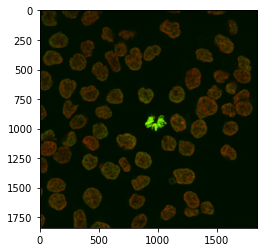

In [6]:
plt.imshow(img_lst[21])

In [7]:
#Step 1
for (n,i) in enumerate(img_lst):
    b,g,r = cv.split(i)
    _,b_mask = cv.threshold(b,30,255,cv.THRESH_TOZERO)
    _,g_mask = cv.threshold(g,30,255,cv.THRESH_TOZERO)
    _,r_mask = cv.threshold(r,30,255,cv.THRESH_TOZERO)
    b_new = cv.bitwise_and(b,b,mask=b_mask)
    g_new = cv.bitwise_and(g,g,mask=g_mask)
    r_new = cv.bitwise_and(r,r,mask=r_mask)
    new = cv.merge([b_new,g_new,r_new])
    img_lst[n] = new

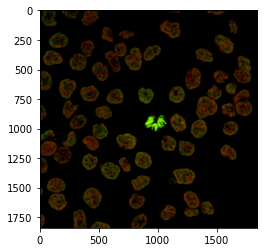

In [8]:
plt.imshow(img_lst[21])

In [9]:
#Step 2
green_low_h = int(128/2)
green_high_h = int(160/2)
green_low_s = int(0/100*255)
green_high_s = int(100/100*255)
green_low_v = int(0/100*255)
green_high_v = int(100/100*255)

low_green = np.array([green_low_h,green_low_s,green_low_v])
high_green = np.array([green_high_h,green_high_s,green_high_v])

blue_low_h = int(190/2)
blue_high_h = int(240/2)
blue_low_s = int(0/100*255)
blue_high_s = int(100/100*255)
blue_low_v = int(0/100*255)
blue_high_v = int(100/100*255)

low_blue = np.array([blue_low_h,blue_low_s,blue_low_v])
high_blue = np.array([blue_high_h,blue_high_s,blue_high_v])

green_masks = []
blue_masks = []
full_masks = []
for (i,img) in enumerate(img_lst):
    img_hsv = bgr2hsv(img)
    
    blue_mask = cv.inRange(img_hsv,low_blue,high_blue)
    green_mask = cv.inRange(img_hsv,low_green,high_green)
    
    green_masks.append(green_mask)
    blue_masks.append(blue_mask)
    full_masks.append(cv.bitwise_or(green_mask,blue_mask))
    
    
    cv.imwrite("/home/devesh/cell-segmentation/blue_masks/"+img_names[i],blue_mask)
    cv.imwrite("/home/devesh/cell-segmentation/green_masks/"+img_names[i],green_mask)
    cv.imwrite("/home/devesh/cell-segmentation/full_masks/"+img_names[i],green_mask)
    

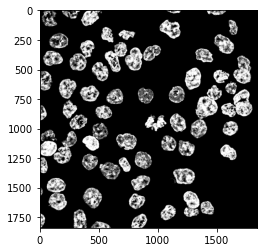

In [10]:
plt.imshow(full_masks[21],cmap="gray")

In [11]:
#Step 3
dilated_imgs = []
kernel_matrix = np.ones((5,5),np.uint8)
iterations = 3
for (i,img) in enumerate(full_masks):
    dilated_imgs.append(dilate(img,kernel_matrix,iterations))

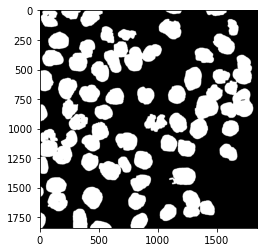

In [12]:
plt.imshow(dilated_imgs[21],cmap="gray")

In [13]:
holeClosed_imgs = []
kernel_matrix = np.ones((7,7),np.uint8)
iterations = 7
for (i,img) in enumerate(dilated_imgs):
    holeClosed_imgs.append(holeClose(img,kernel_matrix,iterations))

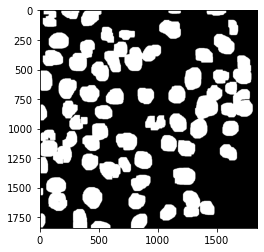

In [14]:
plt.imshow(holeClosed_imgs[21],cmap="gray")

In [15]:
# Distance Transform
distant_imgs = []
mask_size = 0
for img in holeClosed_imgs:
    distant_imgs.append(distTrans(img,mask_size))

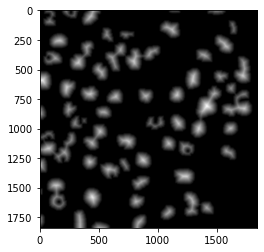

In [16]:
plt.imshow(distant_imgs[21],cmap="gray")

In [17]:
# Sure FG
sure_fgs = []
max_size = 0.3
for img in distant_imgs:
    _,result = cv.threshold(img,max_size*img.max(),255,0) 
    sure_fgs.append(result)

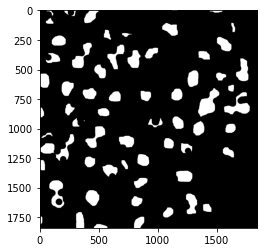

In [18]:
plt.imshow(sure_fgs[21],cmap="gray")

In [19]:
for (i,img) in enumerate(sure_fgs):
    sure_fgs[i] = cv.convertScaleAbs(img)

print(sure_fgs[21].dtype)

uint8


In [45]:
propList = ['Area',
            'intensity_mean',
            'intensity_max',
            'intensity_min']

In [62]:
markers_lst = []
watershed_lst = []
result_imgs = []
regions_lst = []
for (i,img) in enumerate(sure_fgs):
    etc,markers = cv.connectedComponents(img)
    markers = markers+10
    markers_lst.append(markers)
    watershed = cv.watershed(img_lst[i],markers)
    watershed_lst.append(watershed)
    img_lst[i][markers == -1] = [0,255,255]  
    img_res = color.label2rgb(markers, bg_label=0)
    result_imgs.append(img_res)
    regions = measure.regionprops_table(markers, intensity_image=img_lst[i],properties=propList)
    regions = pd.DataFrame(regions)
    regions = regions.drop(columns=["intensity_mean-2","intensity_max-2","intensity_min-2"])
    regions_lst.append(regions)

In [61]:
regions_lst[21].drop(columns=['intensity_mean-2','intensity_max-2','intensity_min-2'],axis=1)
regions_lst[21].columns

Index(['Area', 'intensity_mean-0', 'intensity_mean-1', 'intensity_mean-2',
       'intensity_max-0', 'intensity_max-1', 'intensity_max-2',
       'intensity_min-0', 'intensity_min-1', 'intensity_min-2'],
      dtype='object')

In [47]:
from pandas import ExcelWriter

In [48]:
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)

In [63]:
path = "/home/devesh/cell-segmentation/cell_data.xlsx"

save_xls(regions_lst,path)